In [1]:
import copy
import numpy
import pandas

import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
df_all = (
    pandas.read_csv('data/merged/Wanstead Rainfall Merged.csv')
    .assign(Timestamp=lambda x: pandas.to_datetime(x["Timestamp"]))
)

Merge data from different time periods

In [3]:
df_all.head()

,Timestamp,Rainfall
0,1991-06-01 09:15:00+00:00,0.0
1,1991-06-01 09:30:00+00:00,0.0
2,1991-06-01 09:45:00+00:00,0.0
3,1991-06-01 10:00:00+00:00,0.0
4,1991-06-01 10:15:00+00:00,0.0


In [4]:
df_all.tail()

,Timestamp,Rainfall
1164059,2023-08-20 23:30:00+00:00,0.0
1164060,2023-08-20 23:45:00+00:00,0.0
1164061,2023-08-20 23:45:00+00:00,0.0
1164062,2023-08-20 23:45:00+00:00,0.0
1164063,2023-08-20 23:45:00+00:00,0.0


### Daily Rainfall

Aggregate to daily frequency

In [5]:
df_daily = (
    df_all
    .groupby(by=pandas.Grouper(key='Timestamp', freq='D'))
    .agg({'Rainfall': 'sum'})
)

In [6]:
df_daily.to_csv('data/merged/Wanstead Daily Rainfall Merged.csv')

#### Time-series of daily rainfall

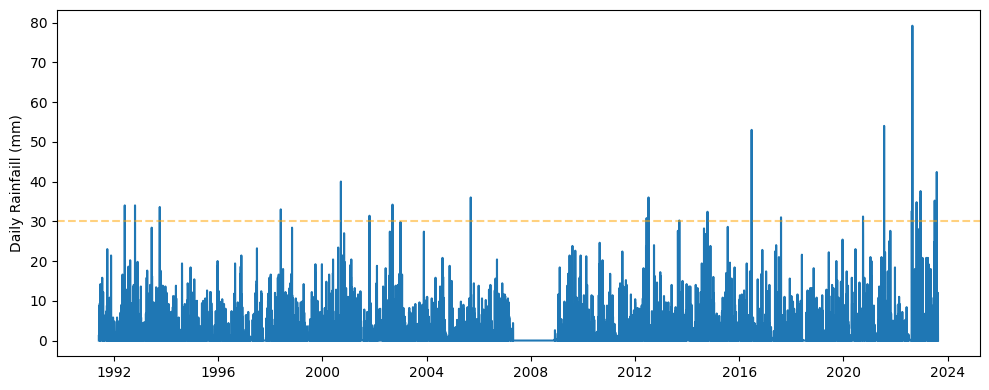

In [7]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(df_daily.index, df_daily['Rainfall'])

ax.set_ylabel('Daily Rainfaill (mm)')

ax.axhline(y=30, ls='--', color='orange', alpha=0.5)

plt.tight_layout()

There is a gap due to the site being offline whilst site works were completed (from FOI request).

#### Days with rainfall exceeding 30 mm

In [8]:
(
    df_daily
    .sort_values(by='Rainfall', ascending=False)
    .loc[lambda x: x["Rainfall"] >= 30]
)

,Rainfall
Timestamp,
2022-08-25 00:00:00+00:00,79.2
2021-07-25 00:00:00+00:00,54.0
2016-06-23 00:00:00+00:00,53.0
2023-08-02 00:00:00+00:00,42.4
2000-09-15 00:00:00+00:00,40.0
2022-12-18 00:00:00+00:00,37.6
2022-12-23 00:00:00+00:00,36.0
2012-07-08 00:00:00+00:00,36.0
2005-09-10 00:00:00+00:00,36.0


#### Number of occurences above a certain threshold

In [9]:
pandas.DataFrame(
    {'Threshold': threshold, 'NEvents': len(df_daily.loc[lambda x: x['Rainfall'] > threshold])}
    for threshold in [15, 20, 25, 30, 35, 40, 45, 50]
).set_index(keys=['Threshold'])

,NEvents
Threshold,
15,175
20,82
25,38
30,23
35,10
40,4
45,3
50,3


There were 15 days where there was more than 30mm of rainfall

#### Distribution of events

Approx. 30 year period, let's consider the probability of rainfall exceeding a value $X$, i.e., survival function but instead of considering survival past a given duration we consider rainfall greater than a certain amount

#### Fit survival function

In [10]:
from lifelines import KaplanMeierFitter, ExponentialFitter, NelsonAalenFitter

In [11]:
# No events are censored
df_daily['Observed'] = 1

obs = df_daily['Rainfall'].values
event = df_daily['Observed'].values

In [12]:
kmf = KaplanMeierFitter().fit(obs, event)

Text(0.5, 0, 'Daily Rainfall (mm)')

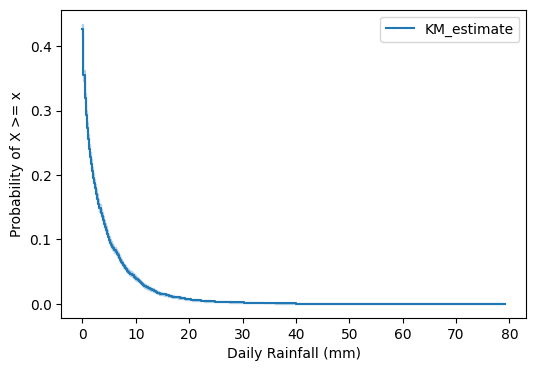

In [13]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

kmf.plot_survival_function(ax=ax)

ax.set_ylabel('Probability of X >= x')
ax.set_xlabel('Daily Rainfall (mm)')

Invert probability to frequency of event

In [14]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.426119
0.2,0.354661
0.4,0.319313
0.6,0.317104
0.6,0.293483
...,...
40.0,0.000340
42.4,0.000255
53.0,0.000170


Text(0.5, 0, 'Daily Rainfall (mm)')

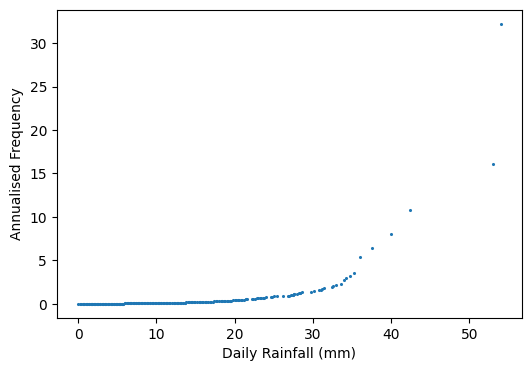

In [15]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

surv_freq = (
    kmf.survival_function_
    .reset_index()
    .assign(
        test=1,
        freq=lambda x: (x['KM_estimate'] ** (-1)) / 365
    )
    .replace({numpy.inf: numpy.nan})
    .dropna()
)

surv_freq.plot(
    ax=ax,
    kind='scatter',
    x='timeline',
    y='freq',
    s=1.5)

ax.set_ylabel('Annualised Frequency')
ax.set_xlabel('Daily Rainfall (mm)')

In [16]:
(
    surv_freq
    .rename(columns={'timeline': 'rainfall'})
    .set_index(keys=['rainfall'])
    .filter(items=['freq'])
    .tail(20)
)

,freq
rainfall,
29.8,1.401906
30.2,1.465629
30.8,1.535421
31.0,1.612192
31.2,1.697044
31.4,1.791324
32.4,1.896696
32.6,2.015240
33.0,2.149589


I.e., 
* observed at least 30mm of rainfall in a day approx. every 2 years
* observed at least 40mm of rainfall in a day approx. every 15 years

### What about rainfall at different measurement frequencies?

The data has measurements every 15 minutes, we can aggregate to different frequencies to distinguish events where there is a lot of rainfall in a short period of time vs. events where there is a lot of rainfall over a long period of time

In [17]:
(
    df_all
    .set_index(keys=['Timestamp'])
    .sort_values(by='Rainfall', ascending=False)
    .head(10)
)

,Rainfall
Timestamp,
2017-06-02 15:00:00+00:00,17.2
2005-09-10 14:45:00+00:00,16.8
2000-08-08 11:15:00+00:00,13.4
2002-08-03 17:00:00+00:00,13.2
2021-07-25 15:45:00+00:00,12.4
2002-07-30 22:15:00+00:00,12.4
2009-06-27 16:45:00+00:00,12.0
1998-05-26 14:45:00+00:00,11.4
2022-12-18 19:30:00+00:00,11.0


Consider rainfall every 2 hours

In [18]:
df_hourly = (
    df_all
    .groupby(by=pandas.Grouper(key='Timestamp', freq='2H'))
    .agg({'Rainfall': 'sum'})
)

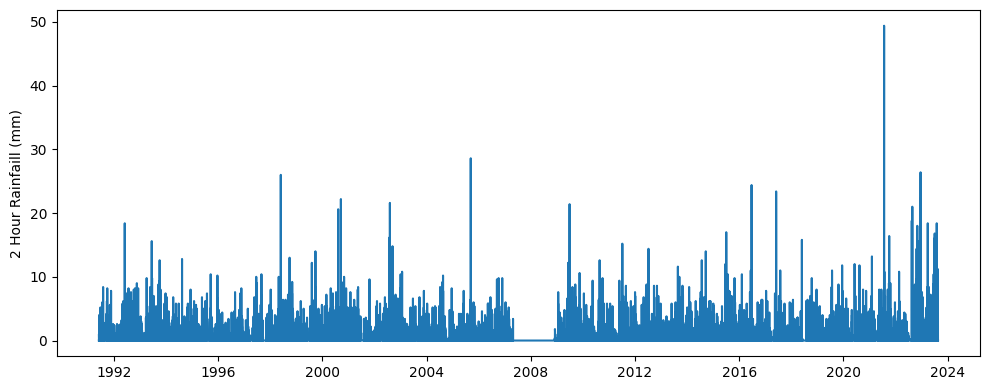

In [19]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(df_hourly.index, df_hourly['Rainfall'])

ax.set_ylabel('2 Hour Rainfaill (mm)')

plt.tight_layout()

In [20]:
(
    df_hourly
    .reset_index()
    .assign(Date=lambda x: x['Timestamp'].dt.date)
    .set_index(keys=['Date', 'Timestamp'])
    .sort_values(by='Rainfall', ascending=False)
    .head(10)
)

,,Rainfall
Date,Timestamp,
2021-07-25,2021-07-25 14:00:00+00:00,49.4
2005-09-10,2005-09-10 14:00:00+00:00,28.6
2022-12-18,2022-12-18 18:00:00+00:00,26.4
1998-05-26,1998-05-26 14:00:00+00:00,26.0
2016-06-23,2016-06-23 00:00:00+00:00,24.4
2017-06-02,2017-06-02 14:00:00+00:00,23.4
2022-12-23,2022-12-23 08:00:00+00:00,22.4
2000-09-15,2000-09-15 12:00:00+00:00,22.2
2002-08-03,2002-08-03 16:00:00+00:00,21.6


In [21]:
# No events are censored
df_hourly['Observed'] = 1

obs = df_hourly['Rainfall'].values
event = df_hourly['Observed'].values

Text(0.5, 0, '2 Hour Rainfall (mm)')

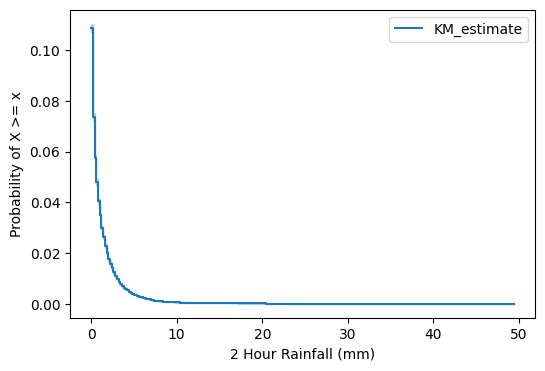

In [22]:
kmf = KaplanMeierFitter().fit(obs, event)

f, ax = plt.subplots(1, 1, figsize=(6, 4))

kmf.plot_survival_function(ax=ax)

ax.set_ylabel('Probability of X >= x')
ax.set_xlabel('2 Hour Rainfall (mm)')

Text(0.5, 0, '2 Hour Rainfall (mm)')

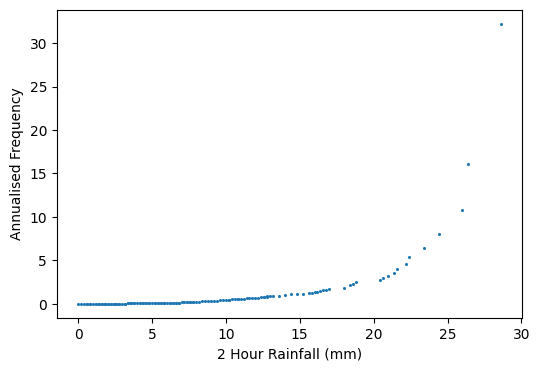

In [23]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))

surv_freq = (
    kmf.survival_function_
    .reset_index()
    .assign(
        test=1,
        freq=lambda x: (x['KM_estimate'] ** (-1)) / (365 * (24/2))
    )
    .replace({numpy.inf: numpy.nan})
    .dropna()
)

surv_freq.plot(
    ax=ax,
    kind='scatter',
    x='timeline',
    y='freq',
    s=1.5)

ax.set_ylabel('Annualised Frequency')
ax.set_xlabel('2 Hour Rainfall (mm)')

### Check rolling window

Previous 2 hour windows were distinct, consider a rolling window to see if this captures any other periods...

In [24]:
df_rolling = (
    df_all
    .set_index(keys=['Timestamp'])
    .rolling(8)
    .sum()
    .fillna(value=0)
)

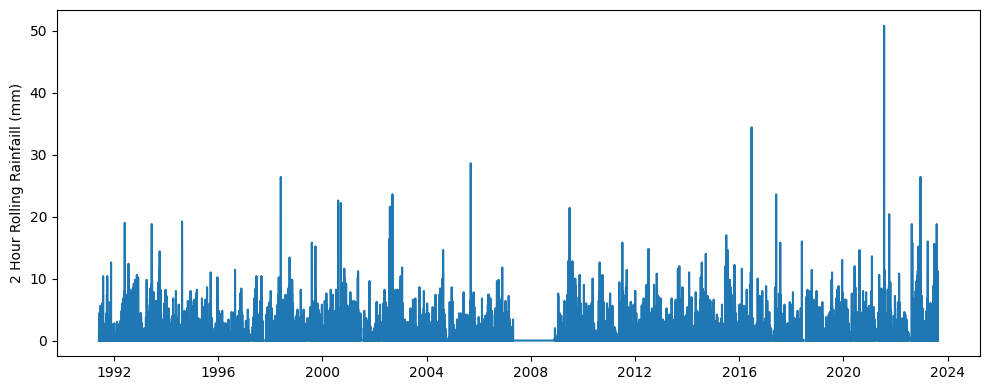

In [25]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(df_rolling.index, df_rolling['Rainfall'])

ax.set_ylabel('2 Hour Rolling Rainfaill (mm)')

plt.tight_layout()

Sort dates by largest amount of rainfall in a 2 hour period

In [26]:
(
    df_rolling
    .reset_index()
    .assign(Date=lambda x: x['Timestamp'].dt.date)
    .set_index(keys=['Date', 'Timestamp'])
    .groupby(by=['Date'])
    .agg({'Rainfall': 'max'})
    .sort_values(by='Rainfall', ascending=False)
    .head(20)
)

,Rainfall
Date,
2021-07-25,50.8
2016-06-23,34.4
2005-09-10,28.6
1998-05-26,26.4
2022-12-18,26.4
2002-09-09,23.6
2017-06-02,23.6
2000-08-08,22.6
2000-09-15,22.2
